<a href="https://colab.research.google.com/github/andreitsev/Machine-Learning-EF-MSU/blob/master/Seminar_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='home'></a>
### Contents

[Imports](#Imports)

[Problem 11](#Problem11)


<a id='Imports'></a>
### Imports
[back to contents](#home)

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
from os.path import join as pjoin
import typing as t
import sys
import time
import itertools
from tqdm import tqdm
import pickle
import json
import joblib
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [6]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [4]:
# Подключение данных гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

<a id='Problem1'></a>
### Problem 1
[back to contents](#home)


In [94]:
items_df = pd.read_pickle('/content/drive/MyDrive/Data/mts_recsys_course/items_preprocessed.pickle')
print(f"items_df: {items_df.shape[0]:,} x {items_df.shape[1]:,}")
items_df.head()

items_df: 59,599 x 5


,id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,247906,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,294280,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [39]:
interactions_df = pd.read_pickle('/content/drive/MyDrive/Data/mts_recsys_course/interactions_preprocessed.pickle')
interactions_df = interactions_df.loc[(~interactions_df['rating'].isnull())].reset_index(drop=True)
# unq_users = interactions_df['user_id'].unique()
unq_users = interactions_df['user_id'].value_counts().index.values[:20_000]
interactions_df = interactions_df.loc[(interactions_df['user_id'].isin(unq_users[:20_000]))].reset_index(drop=True)
interactions_df = interactions_df.loc[:90_000].reset_index(drop=True)
print(f"interactions_df: {interactions_df.shape[0]:,} x {interactions_df.shape[1]:,}")
interactions_df.head()

interactions_df: 47,461 x 5


,user_id,item_id,progress,rating,start_date
0,46791,83486,23,5.0,2018-01-01
1,79313,188770,88,5.0,2018-01-01
2,42797,315927,69,5.0,2018-01-01
3,23439,9762,74,4.0,2018-01-01
4,115029,34757,1,4.0,2018-01-01


In [9]:
# from enum import Enum
from dataclasses import dataclass


@dataclass
class Interaction:
  user_id: str | int
  item_id: str | int
  interaction_weight: float=1.0

  @classmethod
  def from_dict(cls, kwargs):
    return cls(**kwargs)

  def to_dict(self) -> t.Dict[str, t.Any]:
    return {
        "user_id": self.user_id,
        "item_id": self.item_id,
        "interaction_weight": self.interaction_weight
    }

InteractionsType = t.List[Interaction]


In [47]:
Interaction.from_dict({'user_id': 1, 'item_id': 1, 'interaction_weight': 1.0})

Interaction(user_id=1, item_id=1, interaction_weight=1.0)

In [49]:
interactions: InteractionsType = []

for user_id, item_id, rating in tqdm(interactions_df[['user_id', 'item_id', 'rating']].itertuples(index=False)):
  interactions.append(
      Interaction(
          user_id=user_id,
          item_id=item_id,
          interaction_weight=rating
      )
  )
print(len(interactions))

316277it [00:58, 5385.97it/s]


KeyboardInterrupt: 

In [24]:
isinstance(range(4, 10), t.Iterable)

True

In [27]:
res = tqdm_or_identity(iterable=range(int(1e7)), verbose=False)
for i in res:
  i

In [123]:
import gc
from functools import cached_property
from numpy import typing as npt

user_col = 'user_id'
item_col = 'item_id'
rating_col = 'rating'

def tqdm_or_identity(
    iterable: t.Iterable,
    verbose: bool=False,
) -> t.Callable[[t.Iterable], None]:
  if verbose:
    return tqdm(iterable)
  else:
    return iterable



class ALS:

  def __init__(
      self,
      embeddings_dim: int=16,
      reg_coef: float=1.0,
      random_seed: int=59812
    ):
    self.embeddings_dim = embeddings_dim
    self.random_seed = random_seed
    self.reg_coef = reg_coef
    self.user2emb, self.item2emb = {}, {}

  def _initialise_embeddings(self, n_unq_users: int, n_unq_items: int):
    np.random.seed(self.random_seed)
    self.users_embeddings = np.random.normal(size=(n_unq_users, self.embeddings_dim))
    self.items_embeddings = np.random.normal(size=(n_unq_items, self.embeddings_dim))

  def _get_users_embs(self):
    self.user2emb = {
        self.id2user[inner_user_id]: user_emb
        for inner_user_id, user_emb in enumerate(self.users_embeddings)
    }

  def _get_items_embs(self):
    self.item2emb = {
        self.id2item[inner_item_id]: item_emb
        for inner_item_id, item_emb in enumerate(self.items_embeddings)
    }


  @cached_property
  def indentity_matrix(self):
    return np.eye(self.embeddings_dim)

  def _create_adjacency_lists(self, interactions: pd.DataFrame, verbose: bool=False):
    for user_id, item_id, rating in tqdm_or_identity(
        iterable=interactions[[user_col, item_col, rating_col]].itertuples(index=False),
        verbose=verbose
      ):
      user_id, item_id = self.user2id[user_id], self.item2id[item_id]
      if user_id not in self.users_adjacency_lists:
        self.users_adjacency_lists[user_id] = {'items': [], 'ratings': []}
      self.users_adjacency_lists[user_id]['items'].append(item_id)
      self.users_adjacency_lists[user_id]['ratings'].append(rating)
      if item_id not in self.items_adjacency_lists:
        self.items_adjacency_lists[item_id] = {'users': [], 'ratings': []}
      self.items_adjacency_lists[item_id]['users'].append(user_id)
      self.items_adjacency_lists[item_id]['ratings'].append(rating)

  def _create_user_mapping(self, interactions: pd.DataFrame):
    self.user2id = {
        user_id: i for i, user_id in enumerate(interactions[user_col].unique())
    }
    self.id2user = {x: y for y, x in self.user2id.items()}
    self.n_unq_users = len(self.user2id)


  def _create_item_mapping(self, interactions: pd.DataFrame) -> t.Dict[int, int]:
    self.item2id = {
        item_id: i for i, item_id in enumerate(interactions[item_col].unique())
    }
    self.id2item = {x: y for y, x in self.item2id.items()}
    self.n_unq_items = len(self.item2id)

  def delete_intermediate_variables(self):
    del self.users_adjacency_lists
    del self.items_adjacency_lists
    # del self.users_embeddings
    # del self.items_embeddings
    # del self.user2id
    # del self.id2user
    # del self.item2id
    # del self.id2item
    gc.collect();


  def _init_everything(self, verbose: bool=False):
    if verbose: print("\nCreating users mapping...")
    self._create_user_mapping(interactions)
    if verbose: print('users mapping created ✔')
    if verbose: print("Creating items mapping...")
    self._create_item_mapping(interactions)
    if verbose: print('items mapping created ✔')
    if verbose: print("Creating adjacency lists...")
    self._create_adjacency_lists(interactions=interactions, verbose=verbose)
    if verbose: print("adjacency lists created ✔")

    if verbose: print("Initialising users and items embedding...")
    self._initialise_embeddings(n_unq_users=self.n_unq_users, n_unq_items=self.n_unq_items)
    if verbose: print("users and items embedding initialised ✔")

  def fit(self, interactions: pd.DataFrame, epochs: int=20, verbose: bool=False):

    self._init_everything(verbose=verbose)

    if verbose: print('Starting training ...')
    for i in tqdm_or_identity(iterable=range(epochs), verbose=verbose):
      if verbose: print(f"\tEpoch {i+1}")
      self.recompute_users_embeddings()
      self.recompute_items_embeddings()
    if verbose: print('Training finished ✔')

    self._get_users_embs()
    self._get_items_embs()

    # self.delete_intermediate_variables()

    return self

  def _recompute_user_embedding(self, inner_user_id: int) -> npt.NDArray[float]:

    user_items_embs = self.items_embeddings[self.users_adjacency_lists[inner_user_id]['items']]
    user_ratings = np.array(self.users_adjacency_lists[inner_user_id]['ratings'])

    user_new_emb = (
        np.linalg.inv(
            user_items_embs.T @ user_items_embs + self.reg_coef * self.indentity_matrix
        ) @ (user_items_embs.T @ user_ratings)
    )
    return user_new_emb.ravel()

  def _recompute_item_embedding(self, inner_item_id: int) -> npt.NDArray[float]:

    item_users_embs = self.users_embeddings[self.items_adjacency_lists[inner_item_id]['users']]
    item_user_ratings = np.array(self.items_adjacency_lists[inner_item_id]['ratings'])

    item_new_emb = (
        np.linalg.inv(
            item_users_embs.T @ item_users_embs + self.reg_coef * self.indentity_matrix
        ) @ (item_users_embs.T @ item_user_ratings)
    )
    return item_new_emb.ravel()

  def predict(self, user_id: int) -> (
      npt.NDArray[int],  # items indexes
      npt.NDArray[float] # scores
    ):
    items_scores = (self.items_embeddings @ self.users_embeddings[self.user2id[user_id]]).ravel()
    inner_items_idxs_sorted = np.argsort(-items_scores)
    items_scores_sorted = items_scores[inner_items_idxs_sorted]
    items_idxs_sorted = np.array([self.id2item[inner_item_idx] for inner_item_idx in inner_items_idxs_sorted])
    return items_idxs_sorted, items_scores_sorted


  def recompute_users_embeddings(self):
    for inner_user_id in tqdm_or_identity(range(self.n_unq_users), False):
      self.users_embeddings[inner_user_id] = self._recompute_user_embedding(inner_user_id)

  def recompute_items_embeddings(self):
    for inner_item_id in tqdm_or_identity(range(self.n_unq_items), False):
      self.items_embeddings[inner_item_id] = self._recompute_item_embedding(inner_item_id)



In [80]:
als = ALS(embeddings_dim=32)
als.fit(interactions=interactions_df, epochs=50, verbose=True)


Creating users mapping...
users mapping created ✔
Creating items mapping...
items mapping created ✔
Creating adjacency lists...


47461it [00:02, 17255.40it/s]


adjacency lists created ✔
Initialising users and items embedding...
users and items embedding initialised ✔
Starting training ...


  0%|          | 0/50 [00:00<?, ?it/s]

	Epoch 1


  2%|▏         | 1/50 [00:06<05:24,  6.62s/it]

	Epoch 2


  4%|▍         | 2/50 [00:09<03:31,  4.41s/it]

	Epoch 3


  6%|▌         | 3/50 [00:12<02:54,  3.70s/it]

	Epoch 4


  8%|▊         | 4/50 [00:15<02:34,  3.36s/it]

	Epoch 5


 10%|█         | 5/50 [00:20<03:01,  4.03s/it]

	Epoch 6


 12%|█▏        | 6/50 [00:24<02:54,  3.97s/it]

	Epoch 7


 14%|█▍        | 7/50 [00:27<02:35,  3.62s/it]

	Epoch 8


 16%|█▌        | 8/50 [00:29<02:21,  3.37s/it]

	Epoch 9


 18%|█▊        | 9/50 [00:33<02:24,  3.52s/it]

	Epoch 10


 20%|██        | 10/50 [00:39<02:43,  4.08s/it]

	Epoch 11


 22%|██▏       | 11/50 [00:42<02:24,  3.70s/it]

	Epoch 12


 24%|██▍       | 12/50 [00:44<02:11,  3.46s/it]

	Epoch 13


 26%|██▌       | 13/50 [00:47<02:00,  3.26s/it]

	Epoch 14


 28%|██▊       | 14/50 [00:53<02:29,  4.14s/it]

	Epoch 15


 30%|███       | 15/50 [00:56<02:11,  3.75s/it]

	Epoch 16


 32%|███▏      | 16/50 [00:59<01:59,  3.52s/it]

	Epoch 17


 34%|███▍      | 17/50 [01:02<01:49,  3.32s/it]

	Epoch 18


 36%|███▌      | 18/50 [01:08<02:08,  4.03s/it]

	Epoch 19


 38%|███▊      | 19/50 [01:11<02:00,  3.88s/it]

	Epoch 20


 40%|████      | 20/50 [01:14<01:47,  3.57s/it]

	Epoch 21


 42%|████▏     | 21/50 [01:17<01:37,  3.35s/it]

	Epoch 22


 44%|████▍     | 22/50 [01:21<01:42,  3.66s/it]

	Epoch 23


 46%|████▌     | 23/50 [01:26<01:48,  4.00s/it]

	Epoch 24


 48%|████▊     | 24/50 [01:29<01:35,  3.69s/it]

	Epoch 25


 50%|█████     | 25/50 [01:32<01:26,  3.44s/it]

	Epoch 26


 52%|█████▏    | 26/50 [01:35<01:20,  3.36s/it]

	Epoch 27


 54%|█████▍    | 27/50 [01:41<01:35,  4.15s/it]

	Epoch 28


 56%|█████▌    | 28/50 [01:44<01:22,  3.76s/it]

	Epoch 29


 58%|█████▊    | 29/50 [01:47<01:13,  3.48s/it]

	Epoch 30


 60%|██████    | 30/50 [01:50<01:05,  3.30s/it]

	Epoch 31


 62%|██████▏   | 31/50 [01:56<01:17,  4.10s/it]

	Epoch 32


 64%|██████▍   | 32/50 [01:59<01:09,  3.86s/it]

	Epoch 33


 66%|██████▌   | 33/50 [02:02<01:00,  3.56s/it]

	Epoch 34


 68%|██████▊   | 34/50 [02:05<00:53,  3.33s/it]

	Epoch 35


 70%|███████   | 35/50 [02:09<00:55,  3.73s/it]

	Epoch 36


 72%|███████▏  | 36/50 [02:14<00:56,  4.02s/it]

	Epoch 37


 74%|███████▍  | 37/50 [02:17<00:47,  3.68s/it]

	Epoch 38


 76%|███████▌  | 38/50 [02:20<00:41,  3.43s/it]

	Epoch 39


 78%|███████▊  | 39/50 [02:23<00:36,  3.35s/it]

	Epoch 40


 80%|████████  | 40/50 [02:29<00:40,  4.10s/it]

	Epoch 41


 82%|████████▏ | 41/50 [02:32<00:33,  3.73s/it]

	Epoch 42


 84%|████████▍ | 42/50 [02:34<00:27,  3.46s/it]

	Epoch 43


 86%|████████▌ | 43/50 [02:37<00:22,  3.27s/it]

	Epoch 44


 88%|████████▊ | 44/50 [02:43<00:24,  4.03s/it]

	Epoch 45


 90%|█████████ | 45/50 [02:46<00:19,  3.82s/it]

	Epoch 46


 92%|█████████▏| 46/50 [02:49<00:14,  3.52s/it]

	Epoch 47


 94%|█████████▍| 47/50 [02:52<00:09,  3.32s/it]

	Epoch 48


 96%|█████████▌| 48/50 [02:56<00:07,  3.60s/it]

	Epoch 49


 98%|█████████▊| 49/50 [03:01<00:03,  3.97s/it]

	Epoch 50


100%|██████████| 50/50 [03:04<00:00,  3.69s/it]

Training finished ✔


In [81]:
%%time
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(als.users_embeddings)
print(f"X_tsne: {X_tsne.shape[0]:,} x {X_tsne.shape[1]:,}")

X_tsne: 10,000 x 2
CPU times: user 2min 19s, sys: 129 ms, total: 2min 19s
Wall time: 2min 19s


In [82]:
from collections import Counter
from sklearn.cluster import DBSCAN

cluster = DBSCAN(
  eps=1.5,
  min_samples=6,
)
cluster.fit(X_tsne)
print(len(set(cluster.labels_)))
print([(key, cnt) for i, (key, cnt) in enumerate(sorted(dict(Counter(cluster.labels_)).items(), key=lambda x: x[1], reverse=True)) if i <= 5])

408
[(-1, 4287), (1, 1282), (0, 229), (109, 77), (45, 44), (47, 44)]


In [83]:
import matplotlib.colors as colors

np.random.seed(4122)
colors_list = np.random.permutation(list(colors.CSS4_COLORS.keys()))

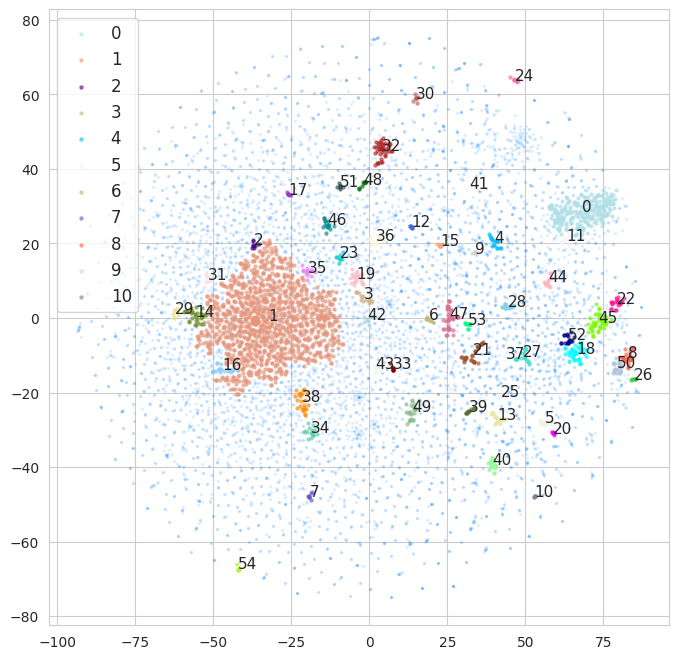

In [84]:
unq_clusters = list(set(cluster.labels_))

plt.scatter(
  X_tsne[:, 0],
  X_tsne[:, 1],
  color='dodgerblue',
  alpha=0.1,
  s=2,
);

for i, cluster_label in enumerate(unq_clusters[:55]):
  plt.scatter(
    X_tsne[cluster.labels_ == cluster_label, 0],
    X_tsne[cluster.labels_ == cluster_label, 1],
    color=colors_list[i % len(colors_list)],
    alpha=0.5,
    s=5,
    label=cluster_label if i <= 10 else None
  );
  plt.text(
    np.mean(X_tsne[cluster.labels_ == cluster_label, 0]),
    np.mean(X_tsne[cluster.labels_ == cluster_label, 1]),
    cluster_label,
    fontsize=11,
  )
plt.legend(fontsize=12);

In [161]:
items_genres_dict = {item_id: [str(genre).strip().lower() for genre in str(genres).split(',' if ',' in str(genres) else '/')] for item_id, genres in items_df[['id', 'genres']].set_index(['id'])['genres'].to_dict().items()}

In [173]:
from IPython.display import display as ipy_display

cluster_id = 18
for cluster_id in [
    24,
    30,
    32,
    34,
    38,
    40,
    45,
    47,
    54,
]:
  users_in_cluster = [als.id2user[inner_user_id] for inner_user_id in np.where(cluster.labels_ == cluster_id)[0]]
  print(f"cluster_id: {cluster_id}")
  cluster_interactions_df = (
      interactions_df.loc[
          (interactions_df['user_id'].isin(users_in_cluster))
      ]
      .assign(genres = lambda x: x['item_id'].map(items_genres_dict))
      .explode('genres')
      .groupby(['user_id', 'genres'])
      ['item_id']
      .count()
      .reset_index()
      ['genres']
      .value_counts()
      .head(15)
  )
  ipy_display(cluster_interactions_df)

cluster_id: 24


,count
genres,
личная эффективность / продуктивность,4
психология,4
интернет-маркетинг,3
зарубежная психология,3
современные любовные романы,2
саморазвитие / личностный рост,2
зарубежная фантастика,2
боевая фантастика,2
зарубежная образовательная литература,2


cluster_id: 30


,count
genres,
мистика,4
триллеры,3
литература 19 века,3
зарубежные детективы,2
детективное фэнтези,2
городское фэнтези,2
ужасы,2
полицейские детективы,2
руководства,2


cluster_id: 32


,count
genres,
попаданцы,19
любовное фэнтези,11
героическое фэнтези,8
историческая фантастика,6
современная русская литература,6
любовно-фантастические романы,6
современные любовные романы,5
эротические романы,5
боевая фантастика,4


cluster_id: 34


,count
genres,
книги по экономике,4
политология,4
юридические журналы,3
бизнес-журналы,3
социальная психология,3
короткие любовные романы,2
любовное фэнтези,2
сказки,2
исторические любовные романы,2


cluster_id: 38


,count
genres,
научная фантастика,4
газеты,2
литература 20 века,2
космическая фантастика,2
социальная психология,2
любовное фэнтези,2
практическая эзотерика,2
общая история,2
зарубежная публицистика,2


cluster_id: 40


,count
genres,
литература 19 века,18
русская классика,18
список школьной литературы 10-11 класс,14
зарубежная классика,6
современные детективы,4
список школьной литературы 5-6 класс,4
научная фантастика,3
космическая фантастика,3
зарубежная фантастика,3


cluster_id: 45


,count
genres,
современные детективы,41
полицейские детективы,32
триллеры,29
зарубежные детективы,26
современная русская литература,25
остросюжетные любовные романы,24
мистика,19
современная зарубежная литература,17
современные любовные романы,16


cluster_id: 47


,count
genres,
саморазвитие / личностный рост,15
зарубежная психология,15
зарубежная прикладная литература,12
практическая психология,11
мотивация,10
современная зарубежная литература,9
героическое фэнтези,8
любовное фэнтези,7
современная русская литература,6


cluster_id: 54


,count
genres,
детская фантастика,5
книги про волшебников,5
научная фантастика,3
современные детективы,1
современная русская литература,1
остросюжетные любовные романы,1
общая психология,1
критика,1
полицейские детективы,1


In [77]:
nontrained_als = ALS(embeddings_dim=32)
nontrained_als._initialise_embeddings(n_unq_users=als.n_unq_users, n_unq_items=als.n_unq_items)

In [78]:
from sklearn.manifold import TSNE

X_tsne_random = TSNE(n_components=2).fit_transform(nontrained_als.users_embeddings)
print(f"X_tsne_random: {X_tsne_random.shape[0]:,} x {X_tsne_random.shape[1]:,}")

X_tsne_random: 10,000 x 2


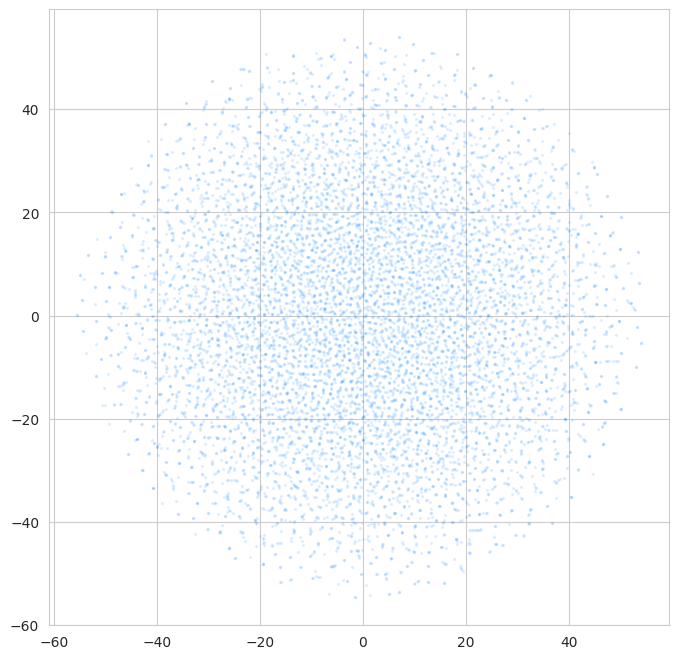

In [79]:
plt.scatter(
  X_tsne_random[:, 0],
  X_tsne_random[:, 1],
  color='dodgerblue',
  alpha=0.1,
  s=2,
);